# Анализ записей ЭЭГ нейроинтерфейса EasyEEG BCI
Регистрация в режиме "Спектр"

(c) Роман Исаков, 2025

## Необходимые библиотеки

In [6]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

## Загрузка сигнала

In [7]:
fileName = 'EEGtst'

eegBands = pd.read_csv(
    fileName+'_bands.csv',
    sep=';',
    decimal=','
)
eegDf = pd.read_csv(
    fileName+'.csv',
    sep=';',
    header=0
)
eegBands.convert_dtypes()

,time,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.01,2.91,31.4,6.34,2.7,1.29,4.17,8.98,2.51,1.29,...,1.69,1.24,1.76,0.16,0.33,0.8,0.31,0.18,0.67,1.17
1,0.02,3.23,31.56,6.16,2.29,1.6,3.85,8.11,2.08,1.11,...,1.62,1.77,2.49,0.05,0.18,0.49,0.56,0.15,0.39,1.67
2,0.03,3.49,32.23,6.57,2.07,1.81,3.71,7.82,1.83,0.96,...,1.94,1.46,2.15,0.11,0.3,0.61,0.39,0.17,0.56,1.43
3,0.04,3.55,32.43,6.66,2.02,1.85,3.67,7.76,1.78,0.92,...,1.89,1.54,2.25,0.09,0.27,0.58,0.44,0.17,0.53,1.51
4,0.05,3.53,32.38,6.63,2.04,1.84,3.7,7.81,1.8,0.94,...,1.86,1.55,2.26,0.09,0.26,0.57,0.45,0.16,0.52,1.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12370,123.71,14.9,0.82,29.27,5.79,2.37,4.55,9.82,5.09,1.59,...,0.4,1.56,1.12,0.46,0.19,0.2,0.68,0.39,0.59,7.32
12371,123.72,14.79,0.85,29.22,5.82,2.43,4.59,9.58,5.17,1.61,...,0.41,1.51,1.2,0.43,0.16,0.21,0.67,0.42,0.6,7.36
12372,123.73,15.02,0.82,29.37,5.81,2.34,4.69,10.2,4.87,1.46,...,0.51,1.51,1.42,0.46,0.1,0.25,0.64,0.5,0.63,7.49
12373,123.74,14.77,0.83,29.13,5.75,2.37,4.39,9.54,5.21,1.67,...,0.65,1.37,1.61,0.54,0.11,0.34,0.57,0.57,0.71,7.47


## Анализ диапазонов ЭЭГ

### Частоно-временной расчет

In [8]:
# Определение доминирующих частотных диапазонов
bands = {
        'delta': (0.5, 3),
        'theta1': (3, 6),
        'theta2': (6, 8),
        'alpha1': (8, 10),
        'alpha2': (10, 12),
        'beta1': (12, 15),
        'beta2': (15, 22),
        'beta3': (22, 35),
        'gamma': (35, 45)
    }
def getDominantFreq(sig, fs):
    freqs, psd = signal.welch(sig, fs, nperseg=255)
    band_powers = {}
    for band, (low, high) in bands.items():
        mask = (freqs >= low) & (freqs <= high)
        band_powers[band] = np.trapezoid(psd[mask], freqs[mask])
    
    return band_powers

band_columns = [f'{key}' for key in getDominantFreq(eegDf['EEG'].iloc[0:255].to_numpy(), 100).keys()]

for col in band_columns:
    if col not in eegDf.columns:
        eegDf[col] = float('nan') 
    else:
        eegDf[col] = eegDf[col].astype('float64')  

for i in range(eegDf['EEG'].count()-255):
    sig = eegDf['EEG'].iloc[i:i+255].to_numpy()
    band_powers = getDominantFreq(sig, 100)
    
    columns_list = [f'{key}' for key in band_powers.keys()]
    values_list = [float(value) for value in band_powers.values()]
    
    eegDf.loc[i + 255 // 2, columns_list] = values_list

### Визуализация частотных диапазонов

/tmp/ipykernel_6938/2227459722.py:57: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax1.set_xlim(start_time, current_end_time)
/tmp/ipykernel_6938/2227459722.py:58: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(start_time, current_end_time)
/tmp/ipykernel_6938/2227459722.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


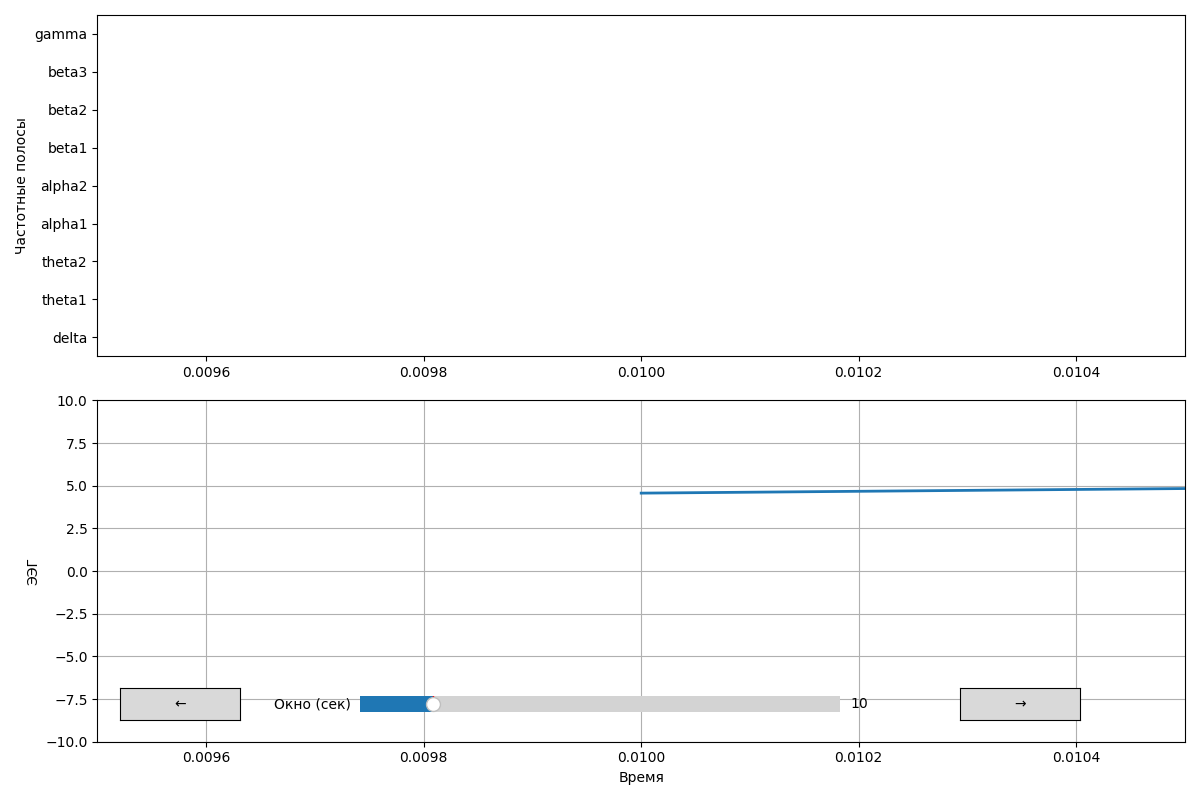

In [9]:
%matplotlib widget

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plt.subplots_adjust(bottom=0.3)

ax_slider = plt.axes([0.3, 0.1, 0.4, 0.04])
ax_left   = plt.axes([0.1, 0.1, 0.1, 0.04])
ax_right  = plt.axes([0.8, 0.1, 0.1, 0.04])

time_slider = Slider(ax_slider, 'Окно (сек)', 1, 60, valinit=10, valstep=1)
left_btn    = Button(ax_left, '←')
right_btn   = Button(ax_right, '→')

full_time = eegDf.time.to_numpy()
full_data_eeg = eegDf['EEG'].to_numpy()
full_data_pcolor = np.transpose(eegDf.iloc[:,2:].to_numpy())

current_end_time = full_time[0] 

def update_plot():
    window_size = time_slider.val
    start_time  = max(current_end_time - window_size, full_time[0])
    
    start_idx = np.argmax(full_time >= start_time)
    end_idx   = np.argmax(full_time >= current_end_time)
    
    if end_idx == 0:
        end_idx = len(full_time) - 1
    
    if hasattr(update_plot, 'pcolor_obj'):
        update_plot.pcolor_obj.remove()
    
    time_window = full_time[start_idx:end_idx+1]
    data_window = full_data_pcolor[:, start_idx:end_idx+1]
    
    update_plot.pcolor_obj = ax1.pcolormesh(
        time_window, 
        [k for k in bands.keys()],
        data_window,
        vmin=0,
        vmax=3,
        cmap='rainbow'
    )
    
    if hasattr(update_plot, 'line_obj'):
        update_plot.line_obj.set_data(
            full_time[start_idx:end_idx+1], 
            full_data_eeg[start_idx:end_idx+1]
        )
    else:
        update_plot.line_obj, = ax2.plot(
            full_time[start_idx:end_idx+1], 
            full_data_eeg[start_idx:end_idx+1],
            linewidth=2
        )
    
    ax1.set_xlim(start_time, current_end_time)
    ax2.set_xlim(start_time, current_end_time)
    fig.canvas.draw_idle()

def slide_left(event):
    global current_end_time
    window_size = time_slider.val
    current_end_time = max(current_end_time - window_size/2, full_time[0] + window_size)
    update_plot()

def slide_right(event):
    global current_end_time
    window_size = time_slider.val
    current_end_time = min(current_end_time + window_size/2, full_time[-1])
    update_plot()

def on_slider_change(val):
    update_plot()

time_slider.on_changed(on_slider_change)
left_btn.on_clicked(slide_left)
right_btn.on_clicked(slide_right)

ax1.set_ylabel('Частотные полосы')
ax2.set_ylim(-10, 10)
ax2.set_xlabel('Время')
ax2.set_ylabel('ЭЭГ')
ax2.grid()

update_plot()
plt.tight_layout()
plt.show()

## Анализ спектрограммы

/tmp/ipykernel_6938/4159178363.py:58: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax1.set_xlim(start_time, current_end_time)
/tmp/ipykernel_6938/4159178363.py:59: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(start_time, current_end_time)
/tmp/ipykernel_6938/4159178363.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


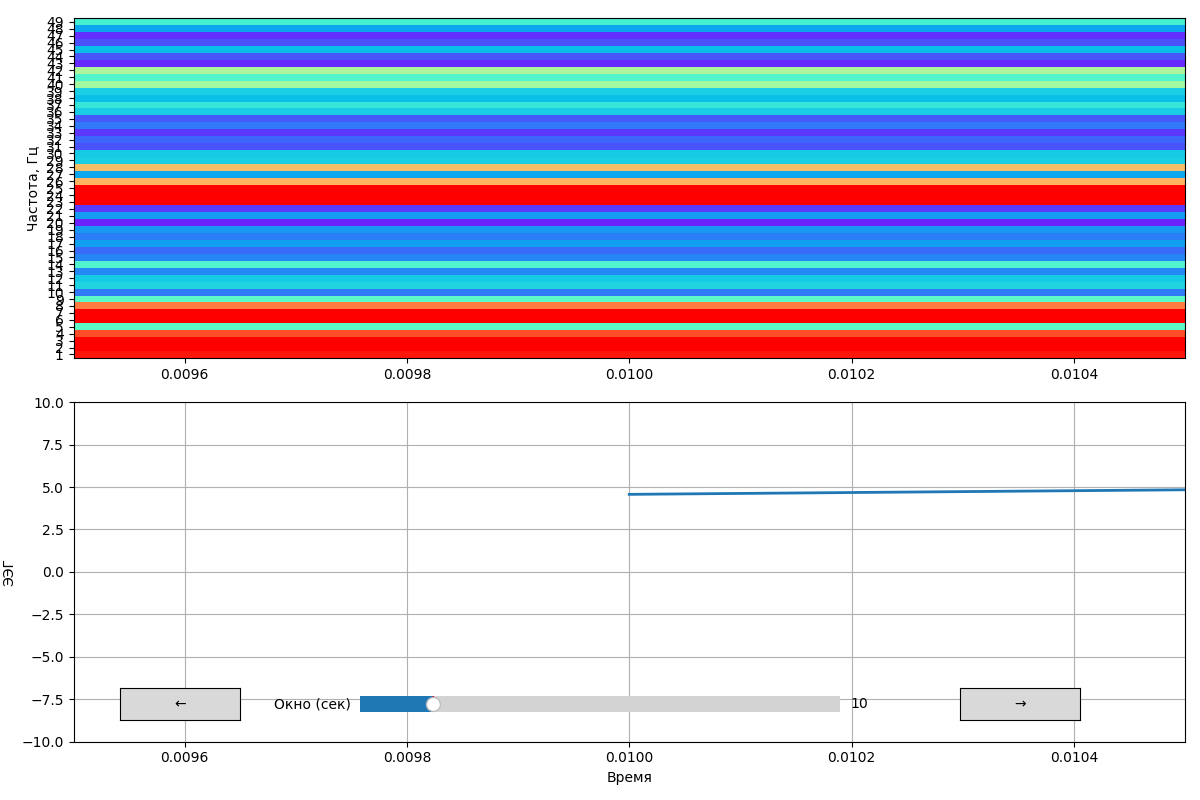

In [10]:
%matplotlib widget

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plt.subplots_adjust(bottom=0.3)

ax_slider = plt.axes([0.3, 0.1, 0.4, 0.04])
ax_left   = plt.axes([0.1, 0.1, 0.1, 0.04])
ax_right  = plt.axes([0.8, 0.1, 0.1, 0.04])

time_slider = Slider(ax_slider, 'Окно (сек)', 1, 60, valinit=10, valstep=1)
left_btn    = Button(ax_left, '←')
right_btn   = Button(ax_right, '→')

# Данные
full_time = eegBands.time.to_numpy()
full_data_eeg = eegDf['EEG'].to_numpy()
full_data_pcolor = np.transpose(eegBands.iloc[:,1:].to_numpy())

current_end_time = full_time[0] 

def update_plot():
    window_size = time_slider.val
    start_time  = max(current_end_time - window_size, full_time[0])
    
    start_idx = np.argmax(full_time >= start_time)
    end_idx   = np.argmax(full_time >= current_end_time)
    
    if end_idx == 0:
        end_idx = len(full_time) - 1
    
    if hasattr(update_plot, 'pcolor_obj'):
        update_plot.pcolor_obj.remove()
    
    time_window = full_time[start_idx:end_idx+1]
    data_window = full_data_pcolor[:, start_idx:end_idx+1]
    
    update_plot.pcolor_obj = ax1.pcolormesh(
        time_window, 
        [k for k in eegBands.iloc[:,1:]],
        data_window,
        vmin=0,
        vmax=3,
        cmap='rainbow'
    )
    
    if hasattr(update_plot, 'line_obj'):
        update_plot.line_obj.set_data(
            full_time[start_idx:end_idx+1], 
            full_data_eeg[start_idx:end_idx+1]
        )
    else:
        update_plot.line_obj, = ax2.plot(
            full_time[start_idx:end_idx+1], 
            full_data_eeg[start_idx:end_idx+1],
            linewidth=2
        )
    
    ax1.set_xlim(start_time, current_end_time)
    ax2.set_xlim(start_time, current_end_time)
    fig.canvas.draw_idle()

def slide_left(event):
    global current_end_time
    window_size = time_slider.val
    current_end_time = max(current_end_time - window_size/2, full_time[0] + window_size)
    update_plot()

def slide_right(event):
    global current_end_time
    window_size = time_slider.val
    current_end_time = min(current_end_time + window_size/2, full_time[-1])
    update_plot()

def on_slider_change(val):
    update_plot()

time_slider.on_changed(on_slider_change)
left_btn.on_clicked(slide_left)
right_btn.on_clicked(slide_right)

ax1.set_ylabel('Частота, Гц')
ax2.set_ylim(-10, 10)
ax2.set_xlabel('Время')
ax2.set_ylabel('ЭЭГ')
ax2.grid()

update_plot()
plt.tight_layout()
plt.show()